# Classification Challenge

Here, we will use a dataset from the UCI Machine Learning collection describing a Portugese bank marketing campaign.  Our goal is whether or not the individual purchased the promoted contract (the `y` column).  Your task is to do some exploratory eda, any feature engineering you feel relevant, and make sure to encode any categorical variables.  Next, your goal is to use `LogisticRegression` to produce the most appropriate classification model.  Consider whether or not this is a precision, recall, or accuracy oriented task and adjust your classifier to optimize the AUC_ROC score.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# chart style
%matplotlib inline
sns.set(style='ticks')

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('data/bank_marketing.csv', index_col=0)

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usag

We want this to be a precision-oriented task because it's better to penalize false positives — people who didn't take the contract but were labeled as they did. We want as many people to take the contract as possible so it's better to overestimate the number of people who didn't.

### examine some of the columns

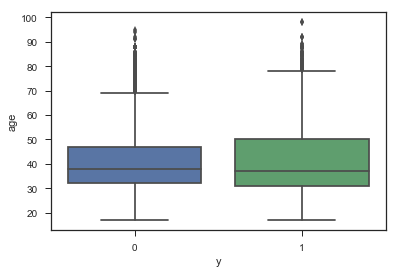

In [6]:
sns.boxplot(x='y',y='age',data=df)

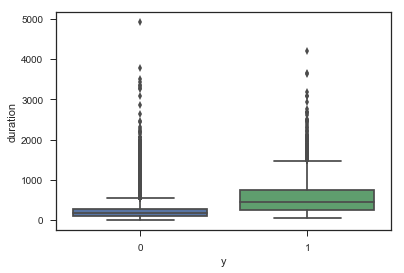

In [8]:
sns.boxplot(x='y',y='duration',data=df)

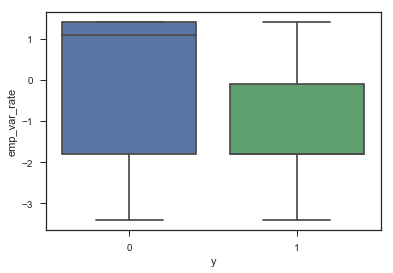

In [11]:
sns.boxplot(x='y',y='emp_var_rate',data=df)

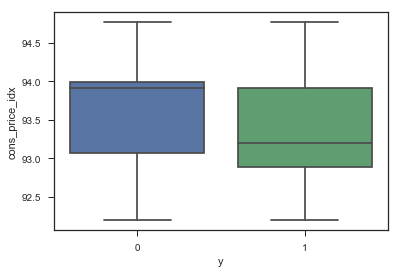

In [12]:
sns.boxplot(x='y',y='cons_price_idx',data=df)

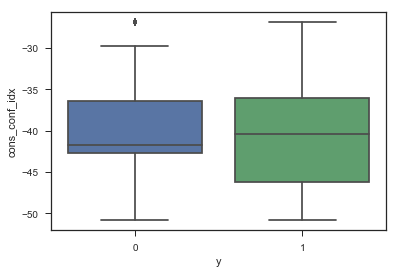

In [13]:
sns.boxplot(x='y',y='cons_conf_idx',data=df)

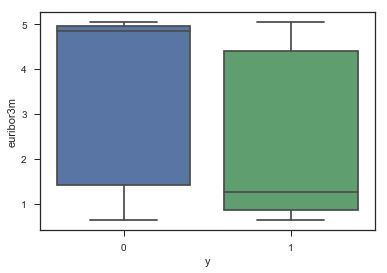

In [14]:
sns.boxplot(x='y',y='euribor3m',data=df)

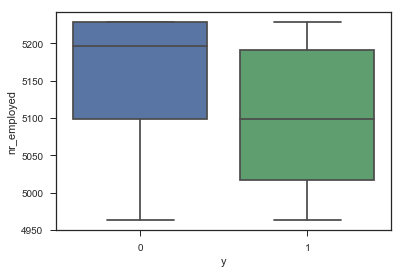

In [15]:
sns.boxplot(x='y',y='nr_employed',data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

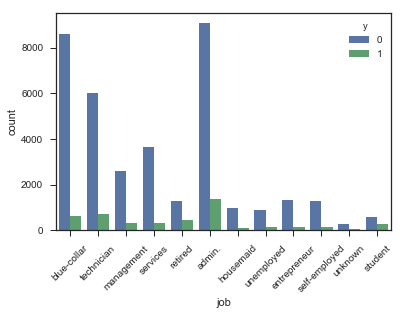

In [39]:
sns.countplot(x='job',hue='y',data=df)
plt.xticks(rotation=45)

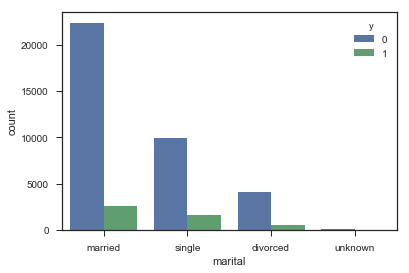

In [41]:
sns.countplot(x='marital',hue='y',data=df)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

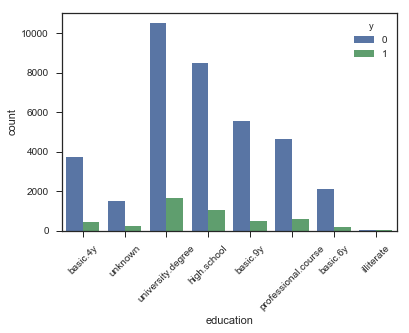

In [43]:
sns.countplot(x='education',hue='y',data=df)
plt.xticks(rotation=45)

### try the model with only numerical variables

In [30]:
# split into numerical and categorical values
num_var = df.select_dtypes(exclude='object').drop('y',axis=1)
cat_var = df.select_dtypes(include='object')

In [31]:
X = num_var
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [32]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      9168
          1       0.65      0.41      0.50      1129

avg / total       0.90      0.91      0.90     10297



### try the model with categorical variables

In [33]:
cat_var_dummies = pd.get_dummies(cat_var,drop_first=True)

In [35]:
X = pd.concat([num_var,cat_var_dummies],axis=1)
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X,y)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      9141
          1       0.64      0.38      0.48      1156

avg / total       0.89      0.91      0.90     10297



### try scaling & using Ridge

In [44]:
from sklearn.preprocessing import StandardScaler

In [52]:
std_scaled = StandardScaler()
cols = num_var.columns
num_var_scaled = std_scaled.fit_transform(num_var[[name for name in cols]])
num_var_scaled = pd.DataFrame(num_var_scaled,columns=cols)

In [54]:
X = num_var_scaled
X_train, X_test, y_train, y_test = train_test_split(X,y)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95      9119
          1       0.68      0.37      0.48      1178

avg / total       0.90      0.91      0.90     10297



In [55]:
X = pd.concat([num_var_scaled,cat_var_dummies],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      9092
          1       0.68      0.43      0.53      1205

avg / total       0.90      0.91      0.90     10297



In [56]:
cross_val_score(clf, X_train, y_train, scoring = 'precision')

array([0.65983607, 0.66478076, 0.65251989])